# [Multi-Class Prediction of Obesity Risk](https://www.kaggle.com/competitions/playground-series-s4e2/overview)
Playground Series - Season 4, Episode 2

(notebook26e4328f51)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import optuna
from optuna.integration import CatBoostPruningCallback
from catboost import CatBoostClassifier, Pool

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
df_train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [4]:
df_train['BMI'] = df_train['Weight'] / (df_train['Height'] ** 2)

In [5]:
numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
target = 'NObeyesdad'

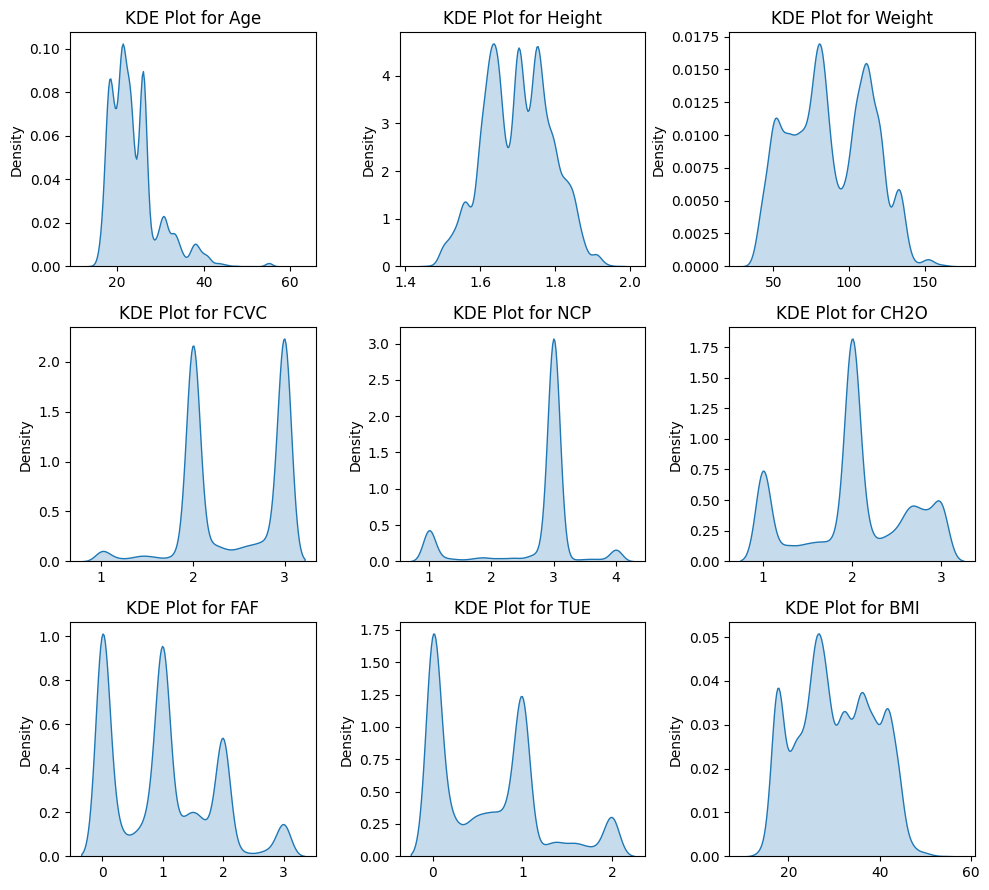

In [6]:
features = numerical_features

num_cols = 3
num_rows = (len(features) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3*num_rows))

if num_rows > 1:
    axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    sns.kdeplot(data=df_train[feature], ax=ax, fill=True)
    ax.set_title(f'KDE Plot for {feature}')
    ax.set_xlabel('')
    ax.set_ylabel('Density')

for i in range(len(features), num_rows * num_cols):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [7]:
for feature in numerical_features:
    df_train[feature] = np.sqrt(df_train[feature])

<Axes: xlabel='count', ylabel='NObeyesdad'>

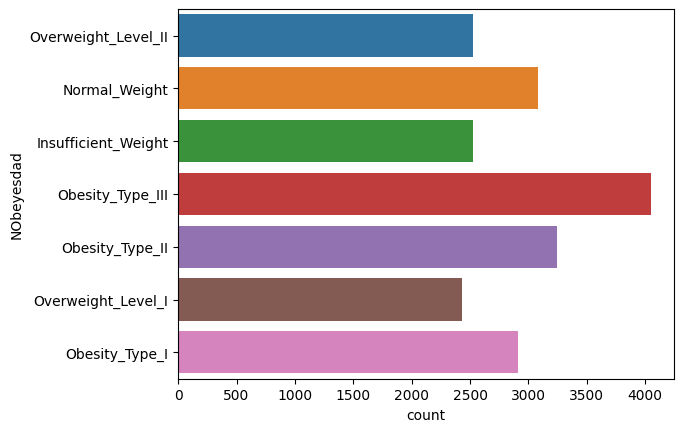

In [8]:
sns.countplot(data=df_train, y=target)

<Axes: xlabel='BMI', ylabel='Density'>

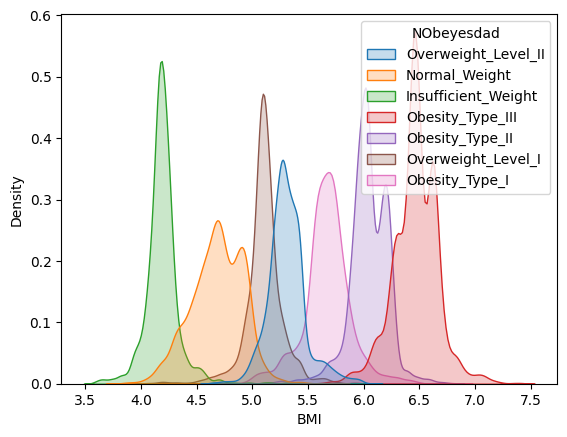

In [9]:
sns.kdeplot(data=df_train, x='BMI', hue=target, fill=True)

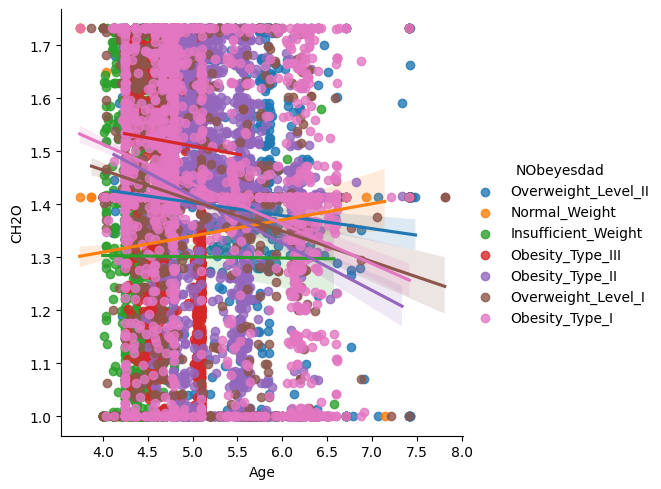

In [10]:
sns.lmplot(data=df_train, x='Age', y='CH2O', hue=target)

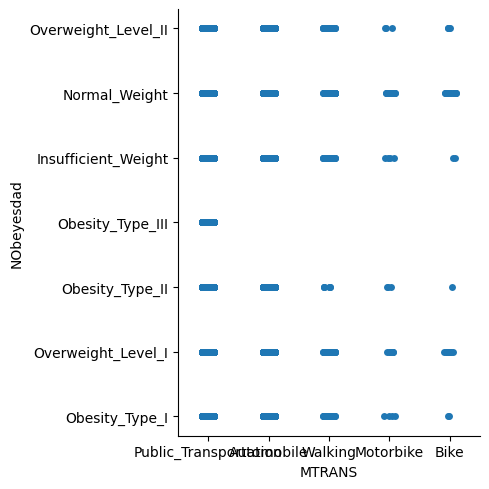

In [11]:
sns.catplot(data=df_train, x='MTRANS', y=target)

In [12]:
X = df_train[[*numerical_features, *categorical_features]]
y = df_train[target]

X.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS
0,4.943987,1.303840,9.037143,1.414214,1.727222,1.662400,0.000000,0.988166,5.315973,Male,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation
1,4.242641,1.249000,7.549834,1.414214,1.732051,1.414214,1.000000,1.000000,4.839637,Female,yes,yes,Frequently,no,no,no,Automobile
2,4.242641,1.308228,7.082779,1.371326,1.188144,1.382164,0.930615,1.293671,4.138442,Female,yes,yes,Sometimes,no,no,no,Public_Transportation
3,4.577416,1.307949,11.457524,1.732051,1.732051,1.293855,1.211554,0.883289,6.697447,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation
4,5.625041,1.383541,9.684940,1.636968,1.404091,1.407071,1.402845,0.965257,5.059560,Male,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation


In [13]:
# def objective(trial):
#     X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8)
#     train_pool = Pool(data=X_train,
#                       label=y_train,
#                       cat_features=categorical_features)
    
#     params = {
#         'iterations': trial.suggest_int('iterations', 120, 240),
#         'depth': trial.suggest_int('depth', 2, 7),
#         'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.4),
#         'loss_function': trial.suggest_categorical('loss_function', ['MultiClass']),
#         'cat_features': trial.suggest_categorical('cat_features', [categorical_features])
#     }
#     # best complects:
#     # 148, 3, 0.27
#     # 194, 5, 0.39
#     # 185, 6, 0.26
    
#     model = CatBoostClassifier(**params)
    
#     pruning_callback = CatBoostPruningCallback(trial, 'MultiClass')
#     model.fit(
#         X_train, y_train, # train_pool ???
#         eval_set=[(X_val, y_val)],
#         verbose=0,
#         early_stopping_rounds=100,
#         callbacks=[pruning_callback]
#     )
    
#     pruning_callback.check_pruned()
    
#     preds = model.predict(X_val)
# #     preds = np.rint(preds)
    
#     return accuracy_score(y_val, preds)

In [14]:
# study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction='maximize')
# study.optimize(objective, n_trials=20, timeout=600)

# print("Number of finished trials: {}".format(len(study.trials)))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: {}".format(trial.value))

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))
    
# # best:
# # iter depth lr
# # 219 6 0.16
# # 221 7 0.21

In [15]:
train_pool = Pool(data=X,
                  label=y,
                  cat_features=categorical_features)

In [16]:
cat_model = CatBoostClassifier(iterations=215, depth=6, learning_rate=0.19,
                               loss_function='MultiClass', early_stopping_rounds=50, verbose=False)

In [17]:
cat_model.fit(train_pool)

In [18]:
y_pred = cat_model.predict(X)
accuracy_score(y_pred, y)

0.9228249349648329

Text(0.5, 1.0, 'Feature Importance')

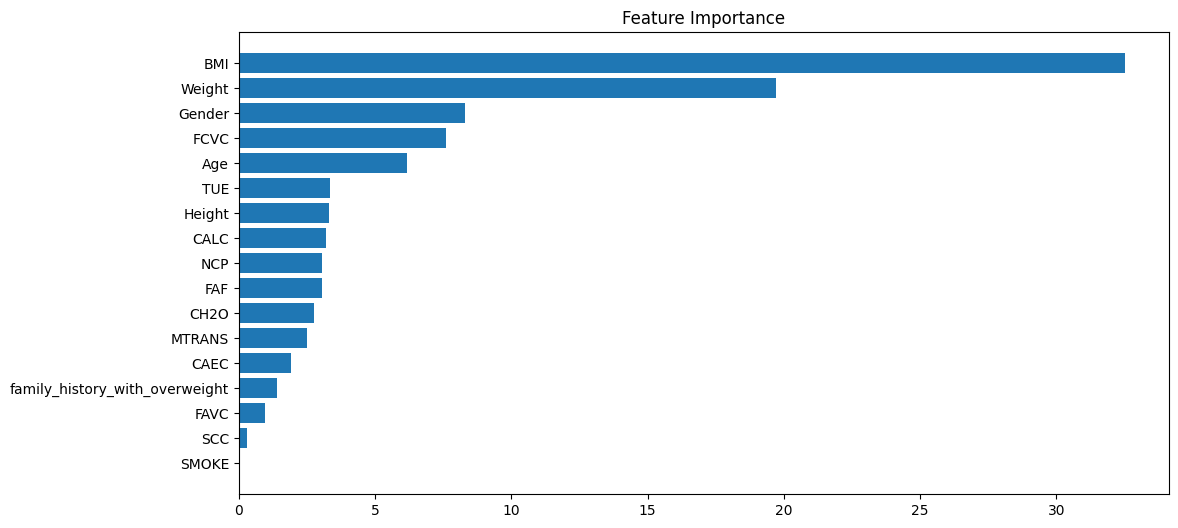

In [19]:
from matplotlib import pyplot as plt

feature_importance = cat_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')

In [20]:
# from sklearn.metrics import confusion_matrix

# sns.heatmap(confusion_matrix(y_pred, y_test), annot=True)

In [21]:
df_test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')
df_test['BMI'] = df_test['Weight'] / (df_test['Height'] ** 2)

for feature in numerical_features:
    df_test[feature] = np.sqrt(df_test[feature])

X = df_test[[*numerical_features, *categorical_features]]

# X = pd.DataFrame(
#         one_hot_encoder.fit_transform(df_test[categorical_features]).toarray(),
#         columns=one_hot_encoder.get_feature_names_out(categorical_features)
#     )
# X = pd.concat([df_test[numerical_features], X], axis=1)

In [22]:
y_pred = cat_model.predict(X)

In [23]:
# y_pred = label_encoder.inverse_transform(y_pred)

In [24]:
output = pd.DataFrame({'id': df_test['id'], target: y_pred.flatten()})
output.to_csv('submission.csv', index=False)